![](https://i.pinimg.com/originals/09/53/81/0953813004d675ca814403fbb649f8b7.png)

## Goals
- Create a machine learning algorithm to predict if a patient has diabetes or not  

## Conclusions
- Major Takeaways:
- Final Model Selected: RandomForest
- Model Metrics:
- Next Steps:

## How to Reproduce:
- [ ] Go over the Readme.md file in the repository of this project [here](https://github.com/ThompsonBethany01/Predicting-Diabetes-Onset).
- [ ] Download Data_Analysis.ipynb and the dataset in your working directory.
- [ ] Run the notebook.

## Thought Process
The predictive variable is the patient being diabetic or not, 0 or 1, making it a classification problem. With a classification problem:
- we create algorithms based on the labeled outcome variable
- this produces a decision rule to classify future data with
- we generalize the trends/patterns in the data to predict the future/unseen data

# Table of Contents <a class="anchor" id="top"></a>
1. [Acquire](#acquire)
2. [Prepare](#prepare)
3. [Explore](#explore)
4. [Modeling](#model)
5. [Final Conclusions](#fin)

In [1]:
# initial imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

#import modules
import Prepare
# import Model

# Acquire <a class="anchor" id="acquire"></a>
Dataset from UCI Machine Learning via Kaggle [here](https://www.kaggle.com/uciml/pima-indians-diabetes-database) saved in .csv file  
#### Steps:
- read csv file into df
- summarize data
- create data dictionary

In [86]:
# needs saved csv file to continue
df = pd.read_csv('diabetes.csv')

In [88]:
print('The dataframe has', df.shape[0], 'rows and', df.shape[1], 'columns.')

The dataframe has 768 rows and 9 columns.


In [89]:
print('The columns are named: ', df.columns.to_list())

The columns are named:  ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']


In [92]:
# What are the data types and null counts for each column?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### What do we learn from df.info()?
- there are no null values
- most columns are integers
- BMI and DPF are decimals (floats)

In [93]:
# what is the distribution of the numeric columns? (All columns)
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


#### What do we learn from df.describe()?
- greatest variation in Insluin
- Many features have a minimum of 0. Is this feasible?
    - someone can not have 0 for BMI, Glucose, or BloodPressure
- Insulin maximum is 846, is this possible or an anamoly cause by a typo? Need to research.

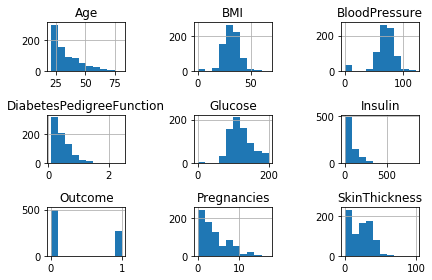

In [7]:
# looking at the distribution of features all at once simply with df.hist()
df.hist()
plt.tight_layout()

### Takeaways
768 observations  
- 8 columns and 1 predictive column as diabetic or not  

All numeric values, integers or floats  
- average diabetic diagnosis is 0, non-diabetic  
- all continuous features except pregnancies and outcome which are discrete  

No null values  
- observations with 0 for values that cannot be, such as BMI and Blood Pressure, have 0 for multiple features  
    - could be null values that were replaced with 0

[Table of Contents](#top)

# Prepare <a class="anchor" id="prepare"></a>
For Exploration:
- create new features by bining demographics  or clustering
    - age into 20s, 30s, etc
    - bmi into low, middle, high
    - blood pressure into low, good, high
    - create features based on clustering

For Modeling:
- split into train, valideate, test
- scale the data - fitting on train df only
- determine if outliers/anomalies to remove (after MVP complete)

## Prepare.py Module contains functions used below
### Prepare.prep_df
- replaces values of 0 in...
    - BMI
    - Glucose
    - BloodPressure  
   with the mean of the feature
   
- bins features with pd.qcut(cuts features into even bins based on number of bins specified)
    - age
    - bmi
    - bloodpressure

- creates feature for patient having both high bloodpressure and bmi

In [9]:
# prepping df before split with function
df = Prepare.prep_df(df)

In [10]:
# quality control, checking the df looks accurate
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_bins,bmi_bins,bp_bins,high_bmi_bp
0,6,148.0,72,35,0,33.6,0.627,50,1,4,2,2,True
1,1,85.0,66,29,0,26.6,0.351,31,0,3,1,1,False
2,8,183.0,64,0,0,23.3,0.672,32,1,3,1,1,False
3,1,89.0,66,23,94,28.1,0.167,21,0,1,1,1,False
4,0,137.0,40,35,168,43.1,2.288,33,1,3,3,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,10,101.0,76,48,180,32.9,0.171,63,0,4,2,2,True
764,2,122.0,70,27,0,36.8,0.340,27,0,2,3,2,False
765,5,121.0,72,23,112,26.2,0.245,30,0,3,1,2,False
766,1,126.0,60,0,0,30.1,0.349,47,1,4,2,1,True


### Prepare.split_df
Splits Data into
- 70% train
- 20% validate
- 10% test  

printing the returned shape of the split df

In [11]:
# splitting df with function
train, validate, test = Prepare.split_df(df)

train shape:  (538, 13) , validate shape:  (153, 13) , test shape:  (77, 13)

train percent:  70.0 , validate percent:  20.0 , test percent:  10.0


In [94]:
# quality control, checking train df looks like the df above but with smaller mixed index
train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,age_bins,...,pregnancy_cluster1,pregnancy_cluster2,pregnancy_cluster3,pregnancy_cluster4,insulin_glucose_cluster,insulin_glucose_cluster1,insulin_glucose_cluster2,insulin_glucose_cluster3,insulin_glucose_cluster4,insulin_glucose_cluster5
279,2,108.0,62,10,278,25.3,0.881,22,0,1,...,0,1,0,0,1,0,1,0,0,0
614,11,138.0,74,26,144,36.1,0.557,50,1,4,...,0,0,0,1,1,0,1,0,0,0
740,11,120.0,80,37,150,42.3,0.785,48,1,4,...,0,0,0,1,1,0,1,0,0,0
113,4,76.0,62,0,0,34.0,0.391,25,0,2,...,0,0,1,0,3,0,0,0,1,0
405,2,123.0,48,32,165,42.1,0.520,26,0,2,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0,104.0,64,37,64,33.6,0.510,22,1,1,...,0,1,0,0,3,0,0,0,1,0
683,4,125.0,80,0,0,32.3,0.536,27,1,2,...,0,0,1,0,0,1,0,0,0,0
624,2,108.0,64,0,0,30.8,0.158,21,0,1,...,0,1,0,0,0,1,0,0,0,0
453,2,119.0,0,0,0,19.6,0.832,72,0,4,...,0,1,0,0,0,1,0,0,0,0


### Prepare.scale_dfs
- Scaling the Data Using Min-Max Scaler
- transforms the range of data points to 0 - 1
- fits scaler to train only, then transforms on all 3 dfs
- returns the split dfs scaled

In [13]:
# calling split df function
X_train_scaled, X_validate_scaled, X_test_scaled = Prepare.scale_dfs(train, validate, test, 'Outcome')

In [95]:
# quality control, does df look the same as train but with scalled values?
X_train_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,age_bins,bmi_bins,...,pregnancy_cluster1,pregnancy_cluster2,pregnancy_cluster3,pregnancy_cluster4,insulin_glucose_cluster,insulin_glucose_cluster1,insulin_glucose_cluster2,insulin_glucose_cluster3,insulin_glucose_cluster4,insulin_glucose_cluster5
279,0.117647,0.412903,0.508197,0.101010,0.328605,0.172330,0.340899,0.019608,0.000000,0.0,...,0,1,0,0,1,0,1,0,0,0
614,0.647059,0.606452,0.606557,0.262626,0.170213,0.434466,0.202141,0.568627,1.000000,1.0,...,0,0,0,1,1,0,1,0,0,0
740,0.647059,0.490323,0.655738,0.373737,0.177305,0.584951,0.299786,0.529412,1.000000,1.0,...,0,0,0,1,1,0,1,0,0,0
113,0.235294,0.206452,0.508197,0.000000,0.000000,0.383495,0.131049,0.078431,0.333333,0.5,...,0,0,1,0,3,0,0,0,1,0
405,0.117647,0.509677,0.393443,0.323232,0.195035,0.580097,0.186296,0.098039,0.333333,1.0,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.000000,0.387097,0.524590,0.373737,0.075650,0.373786,0.182013,0.019608,0.000000,0.5,...,0,1,0,0,3,0,0,0,1,0
683,0.235294,0.522581,0.655738,0.000000,0.000000,0.342233,0.193148,0.117647,0.333333,0.5,...,0,0,1,0,0,1,0,0,0,0
624,0.117647,0.412903,0.524590,0.000000,0.000000,0.305825,0.031263,0.000000,0.000000,0.5,...,0,1,0,0,0,1,0,0,0,0
453,0.117647,0.483871,0.000000,0.000000,0.000000,0.033981,0.319914,1.000000,1.000000,0.0,...,0,1,0,0,0,1,0,0,0,0


### Prepare.create_clusters
- Creating Clusters on Scaled Data
- multitude of parameters allow one function to create any cluster
    - train, validate, and test scaled dfs to fit the cluster model to train only, then transform on all dfs
    - train, validate, test to add the clusters to the unscaled dfs as well for exploration
    - features = what to create the clusters on
    - columns = name of the columns when adding the clusters to the dfs
    - n = number of groups within the cluster to make
    - cluster = name of the original cluster before splitting into dummies
    
#### For each cluster:
1. visualize the number to set for n with elbow test
2. call the function with n set from elbow test

### Age and BMI Cluster

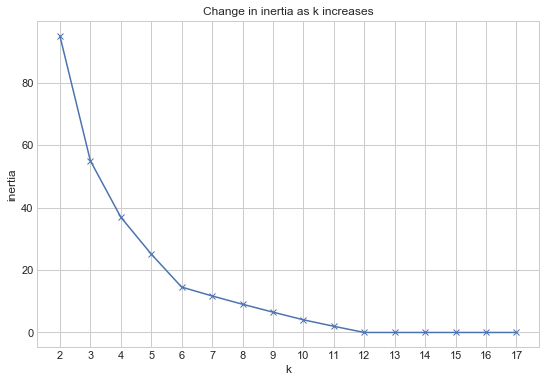

In [96]:
# elbow test to determine n
from sklearn.cluster import KMeans

# features to predict cluster on, only fitting model on X(train)
X = X_train_scaled[['age_bins','bmi_bins']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 4 clusters

In [16]:
# creating cluster with function from Prepare.py

features = ['age_bins','bmi_bins']
columns = ['age_bmi_cluster1','age_bmi_cluster2','age_bmi_cluster3','age_bmi_cluster4']
n = 4
cluster = 'age_bmi_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

### Pregnancy Cluster

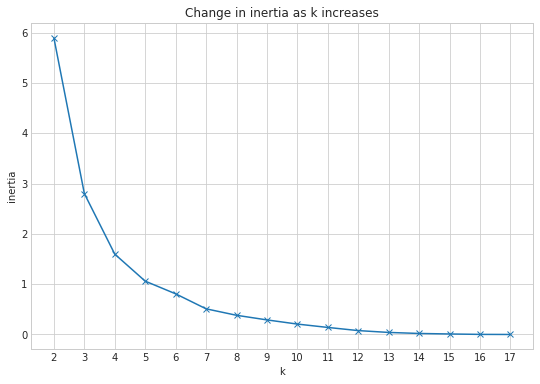

In [17]:
# feature to create cluster on, only fitting model on X(train)
X = X_train_scaled[['Pregnancies']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 4 clusters

In [18]:
# creating cluster with function from Prepare.py

features = ['Pregnancies']
columns = ['pregnancy_cluster1','pregnancy_cluster2','pregnancy_cluster3','pregnancy_cluster4']
n = 4
cluster = 'pregnancy_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

### Insulin and Glucose Cluster

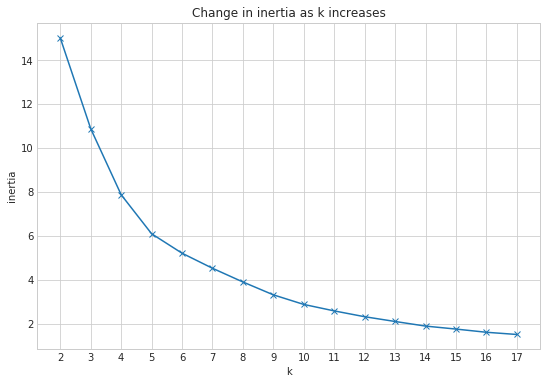

In [19]:
# features to predict cluster on, only fitting model on X(train)
X = X_train_scaled[['Insulin','Glucose']]

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 18)}).plot(marker='x')
    plt.xticks(range(2, 18))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    
# will start with 5 clusters

In [20]:
# creating cluster with function from Prepare.py

features = ['Insulin','Glucose']
columns = ['insulin_glucose_cluster1','insulin_glucose_cluster2','insulin_glucose_cluster3','insulin_glucose_cluster4','insulin_glucose_cluster5']
n = 5
cluster = 'insulin_glucose_cluster'

X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test = Prepare.create_clusters(X_train_scaled, X_validate_scaled, X_test_scaled, train, validate, test, features, n, columns, cluster)

In [21]:
# quality control, do we see the clusters added to the end of train scaled df?
X_train_scaled

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,age_bins,bmi_bins,...,pregnancy_cluster1,pregnancy_cluster2,pregnancy_cluster3,pregnancy_cluster4,insulin_glucose_cluster,insulin_glucose_cluster1,insulin_glucose_cluster2,insulin_glucose_cluster3,insulin_glucose_cluster4,insulin_glucose_cluster5
279,0.117647,0.412903,0.508197,0.101010,0.328605,0.172330,0.340899,0.019608,0.000000,0.0,...,0,1,0,0,1,0,1,0,0,0
614,0.647059,0.606452,0.606557,0.262626,0.170213,0.434466,0.202141,0.568627,1.000000,1.0,...,0,0,0,1,1,0,1,0,0,0
740,0.647059,0.490323,0.655738,0.373737,0.177305,0.584951,0.299786,0.529412,1.000000,1.0,...,0,0,0,1,1,0,1,0,0,0
113,0.235294,0.206452,0.508197,0.000000,0.000000,0.383495,0.131049,0.078431,0.333333,0.5,...,0,0,1,0,3,0,0,0,1,0
405,0.117647,0.509677,0.393443,0.323232,0.195035,0.580097,0.186296,0.098039,0.333333,1.0,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448,0.000000,0.387097,0.524590,0.373737,0.075650,0.373786,0.182013,0.019608,0.000000,0.5,...,0,1,0,0,3,0,0,0,1,0
683,0.235294,0.522581,0.655738,0.000000,0.000000,0.342233,0.193148,0.117647,0.333333,0.5,...,0,0,1,0,0,1,0,0,0,0
624,0.117647,0.412903,0.524590,0.000000,0.000000,0.305825,0.031263,0.000000,0.000000,0.5,...,0,1,0,0,0,1,0,0,0,0
453,0.117647,0.483871,0.000000,0.000000,0.000000,0.033981,0.319914,1.000000,1.000000,0.0,...,0,1,0,0,0,1,0,0,0,0


### Takeaways
- imputed 0 values that could not be 0 with the mean
- created features based on binning
- split the data for exploration and modeling
- scaled the data based on split train df
- created clusters based on split scaled train df

### Next Steps
- are there other clusters that could be more significant in modeling?
- are there outliers/anomalies to deal with?

[Table of Contents](#top)

# Explore <a class="anchor" id="explore"></a>
- determine trends in patient being diabetic or not
    - X feature(s) vs. Outcome
- test the significance with hypothesis testing, such as with:
    - t-test
    - chi-squared contingancy table
    - ANOVA test
- explore interaction of independent features to determine what clusters to create
- visualize clusters created

Text(0, 0.5, 'Count of Patients')

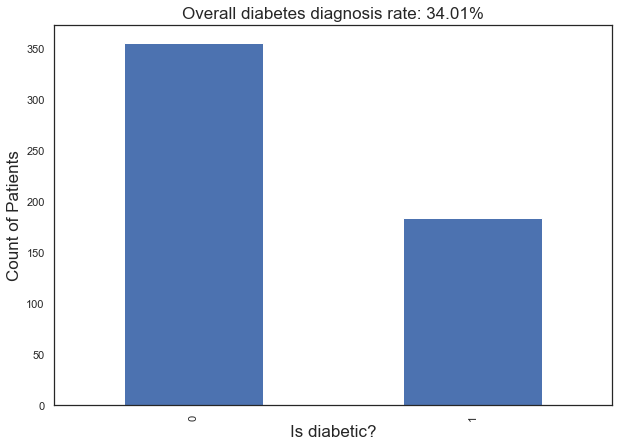

In [107]:
# visualizing distribution of Y feature (predictive variable)
plt.figure(figsize=(10,7))
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=17)
plt.xlabel('Is diabetic?', size=17)
plt.ylabel('Count of Patients', size=17)

### Overall, most patients are not diagnosed with diabetes.

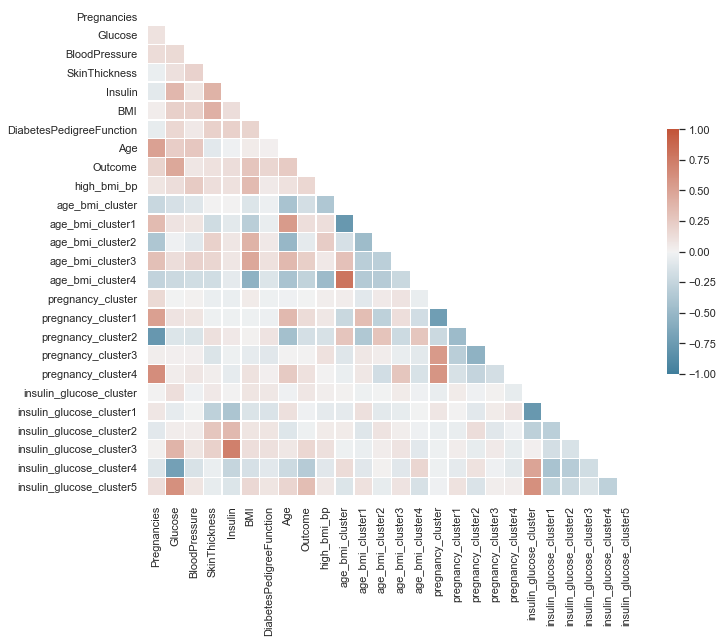

In [110]:
# visualizing overall linear correlation of all features
corr = train.corr()

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmin=-1, vmax=1)

### Outcome has strongest correlation with Glucose, which is also reflected later in model. This feature had the strongest importance for all modeling algorithms.
#### Note: Features can have non-linear correlation, which would not be captured in this heatmap.

## Looking at Independent Features vs. Diabetic Outcome
### Diagnosis Rate within Subgroups of Age, BMI, and BP Bins

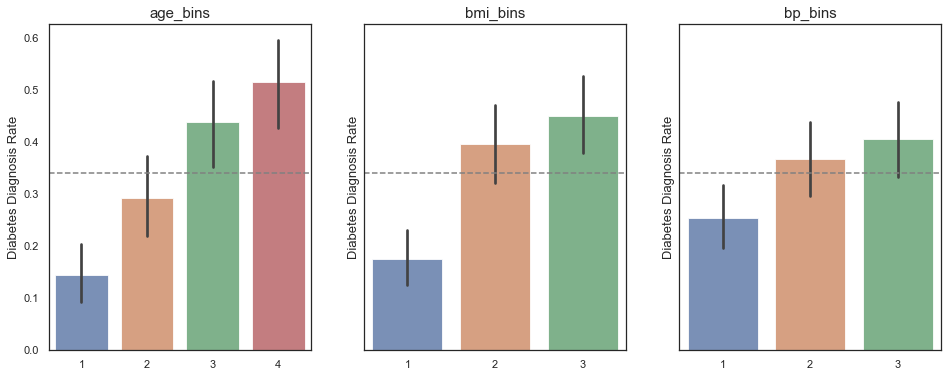

In [24]:
# visualizing subgroups within feature bins, is there a significant difference of diabetic diagnosis?
# categorical features we can compare
features = ['age_bins', 'bmi_bins', 'bp_bins']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

Notes:
- Age bins have higher diagnosis rates in the older bins.
- BMI bins have higher diagnosis rates at higher BMI
- BloodPressure bins have higher diagnosis rates at higher bloodpressure

## Statistically Testing these Hypothesis Seen in Visuals

### Age vs. Diabetes Diagnosis
$H_O$: There is no significant difference between age and diabetes diagnosis.   
$H_a$: Older populations have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage).

### BMI vs. Diabetes Diagnosis
$H_O$: There is no significant difference between age and diabetes diagnosis.  
$H_a$: Populations with higher BMI have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage).

### BloodPressure vs. Diabetes Diagnosis
$H_O$: There is no significant difference between age and diabetes diagnosis.  
$H_a$: Populations with higher blood pressure have a significantly higher rate of diabetes (in female patients +21 with Pima Indian heritage).

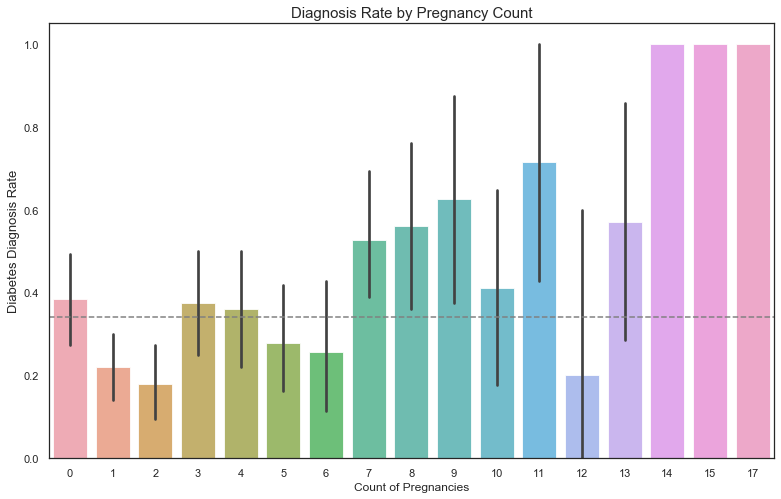

In [25]:
# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

plt.figure(figsize=(13,8))

# plotting pregnancy count diagnosis rate and comparing to overall with dashed line
sns.barplot('Pregnancies', 'Outcome', data=train, alpha=.8)
plt.xlabel('Count of Pregnancies')
plt.ylabel('Diabetes Diagnosis Rate', size=13)
plt.title('Diagnosis Rate by Pregnancy Count', size=15)
plt.axhline(diabetic_rate, ls='--', color='grey')

In [26]:
# note the few amount of pregnancies at 10 and higher
train[train.Outcome == 1].Pregnancies.value_counts()

0     28
1     22
7     19
3     18
4     18
8     14
2     13
5     12
9     10
6      9
10     7
11     5
13     4
15     1
12     1
14     1
17     1
Name: Pregnancies, dtype: int64

Text(0.5, 1.0, 'Diabetes Diagnosis by Pregnancy Count and Glucose')

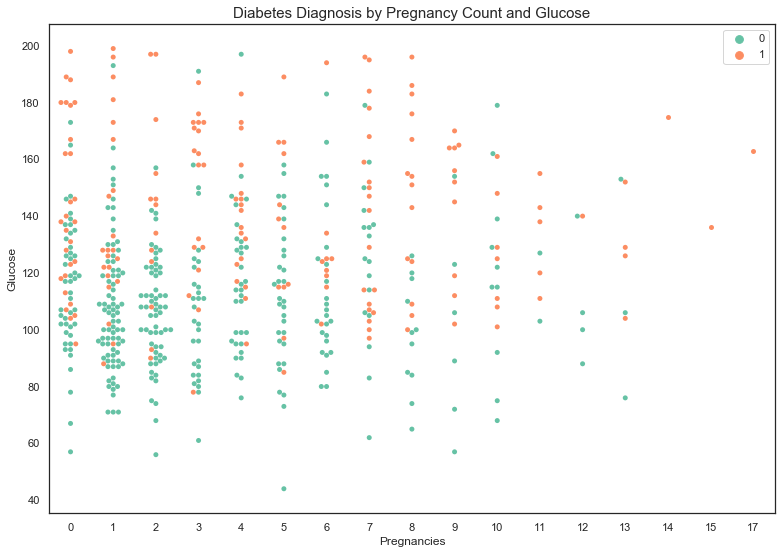

In [27]:
plt.figure(figsize=(13,9))
sns.swarmplot(x="Pregnancies", y="Glucose", data=train, hue="Outcome", palette="Set2")
plt.legend()
plt.title('Diabetes Diagnosis by Pregnancy Count and Glucose', size=15)

Text(0.5, 1.0, 'Diabetes Diagnosis by Age and BMI Bins')

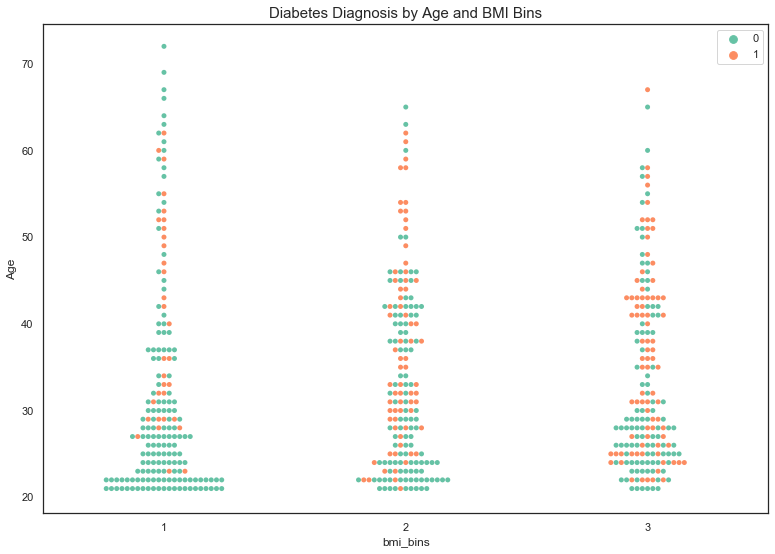

In [28]:
plt.figure(figsize=(13,9))
sns.swarmplot(x="bmi_bins", y="Age", data=train, hue="Outcome", palette="Set2")
plt.legend()
plt.title('Diabetes Diagnosis by Age and BMI Bins', size=15)

Text(0.5, 1, 'Diabetes Diagnosis with BMI vs. Glucose')

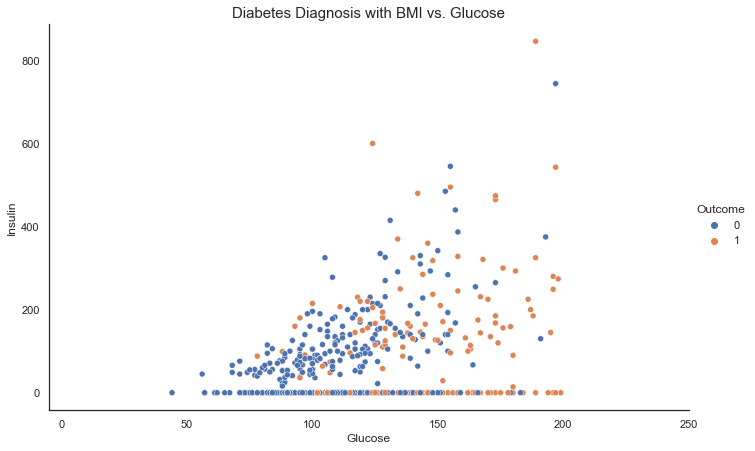

In [29]:
sns.relplot(x="Glucose", y="Insulin", hue="Outcome", data=train, height=6, aspect=1.6)
plt.xlim(-5, 250)
plt.title('Diabetes Diagnosis with BMI vs. Glucose', size=15)

### Exploring Interaction of X Variables

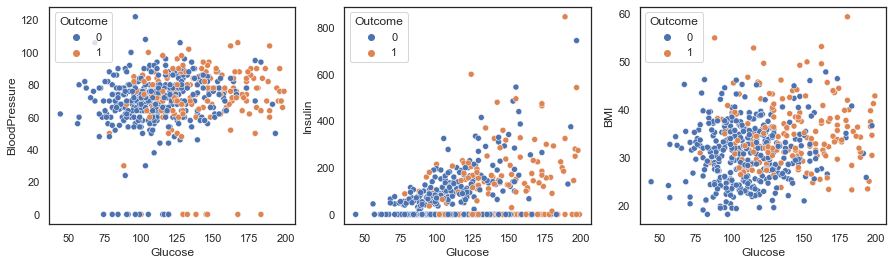

In [31]:
plt.figure(figsize=(15,4))

plt.subplot(131)
sns.scatterplot(x=train.Glucose, y=train.BloodPressure, hue=train.Outcome)

plt.subplot(132)
sns.scatterplot(x=train.Glucose, y=train.Insulin, hue=train.Outcome)

plt.subplot(133)
sns.scatterplot(x=train.Glucose, y=train.BMI, hue=train.Outcome)

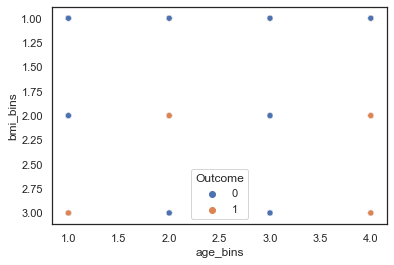

In [32]:
sns.scatterplot(x=train.age_bins, y=train.bmi_bins, hue=train.Outcome)

## Exploring Clusters
- is there significant difference between the individual cluster groups?
- visually and with statistical testing

#### Clusters to Test
- age_bmi_cluster
- pregnancy_cluster

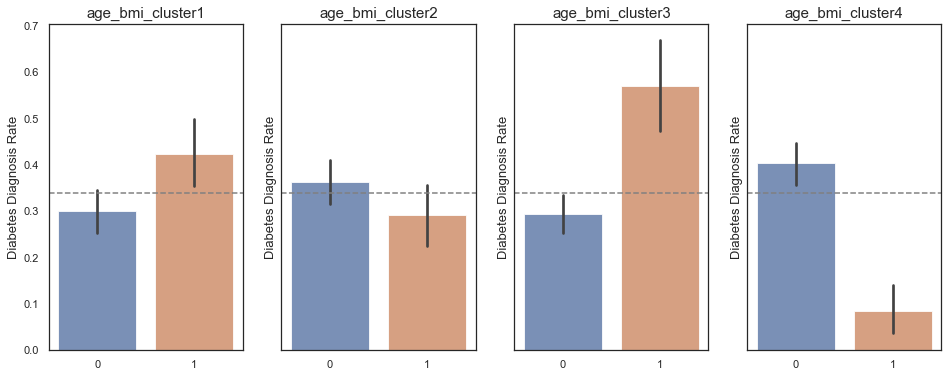

In [33]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['age_bmi_cluster1', 'age_bmi_cluster2', 'age_bmi_cluster3','age_bmi_cluster4']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

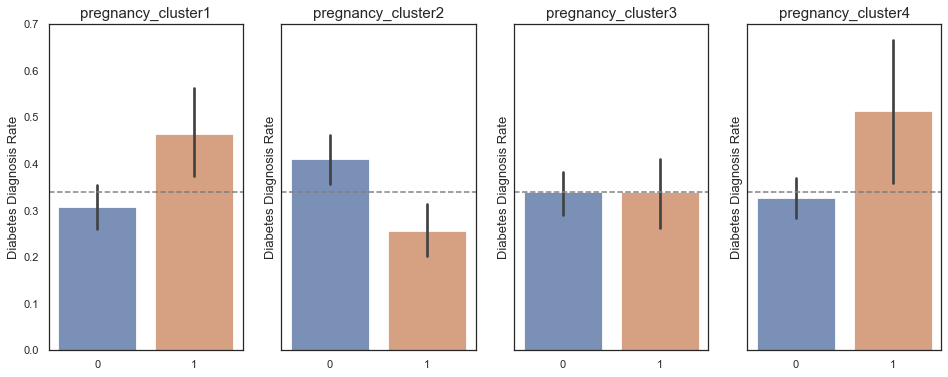

In [34]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['pregnancy_cluster1', 'pregnancy_cluster2', 'pregnancy_cluster3','pregnancy_cluster4']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

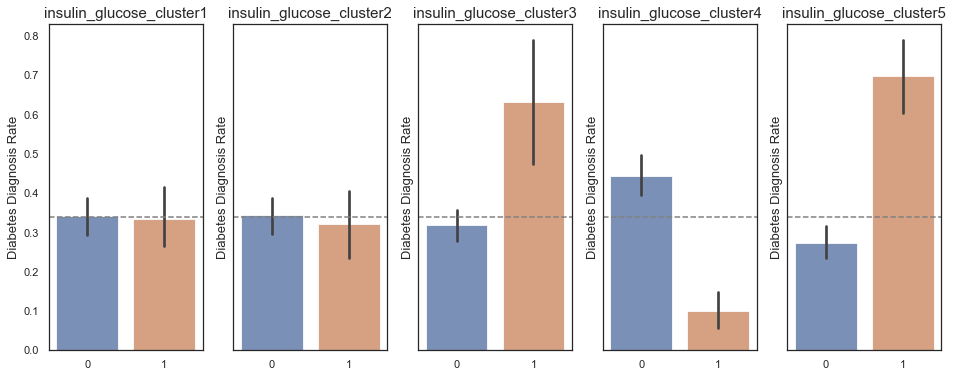

In [35]:
# comparing the dummy variables created from the age_bmi_cluster
features = ['insulin_glucose_cluster1', 'insulin_glucose_cluster2', 'insulin_glucose_cluster3','insulin_glucose_cluster4','insulin_glucose_cluster5']

# overall diagnosis of diabetes on whole train df
diabetic_rate = train.Outcome.mean()

# plotting subgroups diagnosis rate and comparing to overal with dashed line
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(16, 6), sharey=True)
for i, feature in enumerate(features):
    sns.barplot(feature, 'Outcome', data=train, ax=ax[i], alpha=.8)
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Diabetes Diagnosis Rate', size=13)
    ax[i].set_title(feature, size=15)
    ax[i].axhline(diabetic_rate, ls='--', color='grey')

### Takeaways


### Next Steps
- create clusters for new features based on BMI, age, etc.
- bin more continuous variables

[Table of Contents](#top)

# Modeling <a class="anchor" id="model"></a>
##### Outcome of patient being diabetic or not is the predictive feature, Y
#### Steps
1. Create the Baseline model for comparison based on most common diagnosis
2. Create models fit to the train df only
3. Validate on top 3 models, tuning hyperparameters
4. Use final top model evaluated on test
5. Determine next steps/conclusions

### Baseline

In [36]:
train.Outcome.value_counts()

0    355
1    183
Name: Outcome, dtype: int64

Text(0, 0.5, 'Count of Patients')

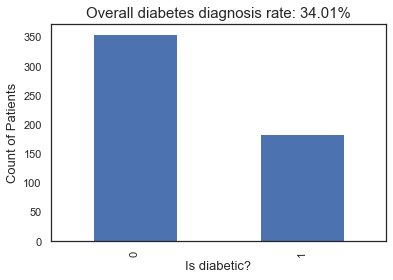

In [37]:
# taking a look at the same barplot again, overall rate of diabetes diagnosis
train.Outcome.value_counts().sort_index().plot.bar()
diabetic_rate = train.Outcome.mean()
plt.title(f"Overall diabetes diagnosis rate: {diabetic_rate:.2%}", size=15)
plt.xlabel('Is diabetic?', size=13)
plt.ylabel('Count of Patients', size=13)

In [38]:
y_train = train[['Outcome']]

In [39]:
# most common diagnosis is non-diabetic, this will be our baseline
y_train['baseline_prediction'] = 0

baseline_accuracy = (y_train.baseline_prediction == train.Outcome).mean()

print(f'baseline accuracy: {baseline_accuracy:.2%}')

baseline accuracy: 65.99%


## Creating Classification Models
#### Models to Create
- LogisticRegression
- DecisionTree
- RandomForest
- KNN
- RidgeClassifier Model
- SGDClassifier

#### Primary Evaluation Metric
Is it more dangerous to predict diabetic when actually not, or not diabetic when actually diabetic? 
   - It is better to predict Diabetic because a patient not being diagnosed could lead to harm to the patient
   - We want the model to predict 1 better, aka have a higher recall score and precision
       - recall: 
       - TP / (TP + FN)
       - % of acually positive cases that were predicted as positive
       - Optimize for recall when missing actual positive cases is expensive or deadly

In [40]:
# modeling imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier

# SelectKBest features
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

# evaluation metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [41]:
# splitting into X and y
X_train = X_train_scaled
y_train = y_train[['Outcome']]

## Creating Models on Train
- What features are most important in the model?

### Logistic Regression Model

In [42]:
# create model object
logit = LogisticRegression(C=10)

# fit to train
logit.fit(X_train, y_train)

# predict on train
y_pred = logit.predict(X_train)

#evaluate
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logit.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.78


In [43]:
print('Coefficient: \n', logit.coef_)
print('Intercept: \n', logit.intercept_)

Coefficient: 
 [[ 0.27823592  5.07480574 -1.15101929  0.58695246 -0.60878827  3.67603993
   1.73547167 -2.34897163  2.99660457 -0.20356761 -0.4544107   0.3765252
  -0.0734427  -0.14004247 -0.01045019 -0.06366179  0.02144369 -0.0874022
  -0.08718769 -0.13369697  0.03822694 -0.01005304 -0.09519719  0.10534806
  -0.1845271  -0.08876215 -0.36593248  0.34116291]]
Intercept: 
 [-4.69357951]


In [44]:
print(confusion_matrix(y_train, y_pred))

[[312  43]
 [ 73 110]]


In [45]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       355
           1       0.72      0.60      0.65       183

    accuracy                           0.78       538
   macro avg       0.76      0.74      0.75       538
weighted avg       0.78      0.78      0.78       538



## Decision Tree Model

Text(0, 0.5, 'feature')

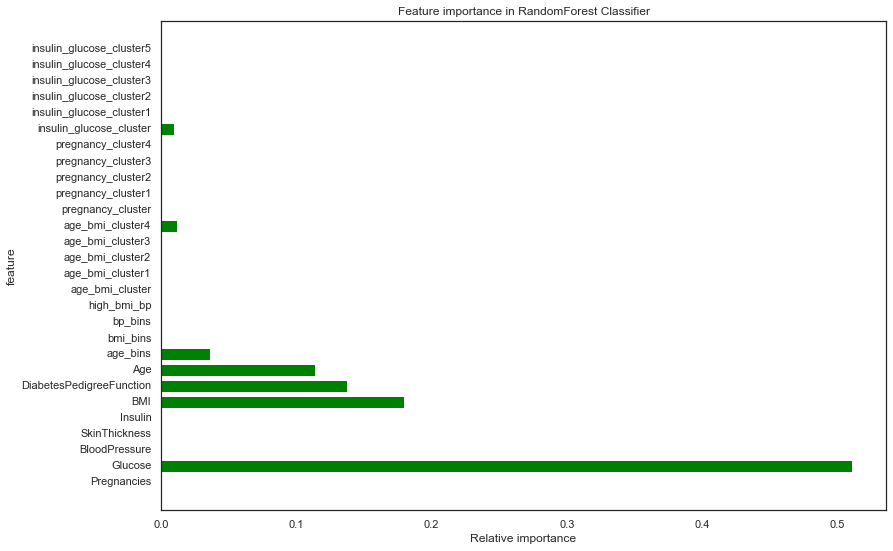

In [46]:
X_train = X_train_scaled

# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# fit to train
clf.fit(X_train, y_train)

col = X_train_scaled.columns

#modelname.feature_importance_
y = clf.feature_importances_

#plot
fig, ax = plt.subplots(figsize=(13,9)) 
width = .75 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
plt.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature')

In [76]:
# features to model on
X_train = X_train_scaled[['Glucose','BMI','DiabetesPedigreeFunction','Age']]

# create the model
clf = DecisionTreeClassifier(max_depth=5, random_state=123)

# fit to train
clf.fit(X_train, y_train)

# predict on train
y_pred = clf.predict(X_train)

# evaluate
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.85


In [77]:
confusion_matrix(y_train, y_pred)

array([[327,  28],
       [ 55, 128]])

In [78]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       355
           1       0.82      0.70      0.76       183

    accuracy                           0.85       538
   macro avg       0.84      0.81      0.82       538
weighted avg       0.84      0.85      0.84       538



## Random Forest Model
- visualize feature importance for model
- model on specific features

In [50]:
X_train = X_train_scaled

In [51]:
# create the model
rf = RandomForestClassifier(max_depth=5, random_state=123)

# fit to train
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [52]:
col = X_train_scaled.columns

#modelname.feature_importance_
y = rf.feature_importances_

Text(0, 0.5, 'feature')

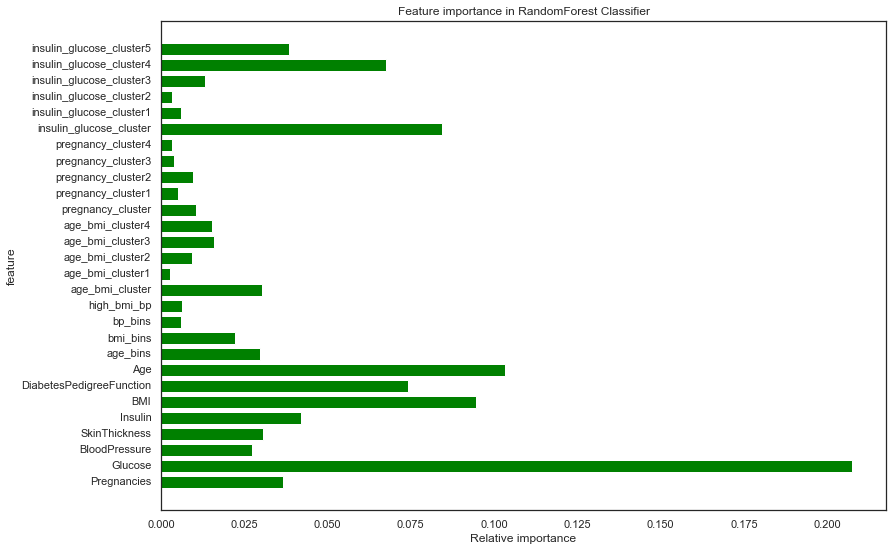

In [53]:
#plot
fig, ax = plt.subplots(figsize=(13,9)) 
width = .75 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
plt.barh(ind, y, width, color="green")
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=False)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature')

In [54]:
# features to model on
X_train = X_train_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]

# create the model
rf = RandomForestClassifier(max_depth=5, random_state=123)

# fit to train
rf.fit(X_train, y_train)

# predict on train
y_pred = rf.predict(X_train)

# evaluate
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.86


In [55]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.94      0.90       355
           1       0.86      0.69      0.77       183

    accuracy                           0.86       538
   macro avg       0.86      0.82      0.83       538
weighted avg       0.86      0.86      0.85       538



In [56]:
print(rf.feature_importances_)

[0.36396477 0.17927198 0.18993834 0.13067269 0.13615222]


## KNN Model

In [62]:
# initialize the ML algorithm
lm = LinearRegression()

# create the rfe object, indicating the ML object (lm) and the number of features to select
rfe = RFE(lm, 12)

# fit the data using RFE
rfe.fit(X_train_scaled,y_train.Outcome)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()

In [63]:
# Features elected by SelectKBest
print('SelectKBest Top 12 Features:')
rfe_feature

SelectKBest Top 12 Features:


['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'age_bins',
 'bp_bins',
 'high_bmi_bp',
 'age_bmi_cluster4']

In [64]:
# 10 features have the same rank of 1
rfe.ranking_

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  4,  1,  1,  8,  9,  6,  7,  1,
       11, 14, 16, 17, 13, 15,  3,  5, 10, 12,  2])

In [65]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# create the model
knn = KNeighborsClassifier(n_neighbors=5)

# fit to train
knn.fit(X_train, y_train)

# predict on train
y_pred = knn.predict(X_train)

# evaluate
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.81


In [66]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.92      0.86       355
           1       0.79      0.59      0.67       183

    accuracy                           0.81       538
   macro avg       0.80      0.75      0.77       538
weighted avg       0.80      0.81      0.80       538



## RidgeClassifier Model

In [67]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# create the model object
clf = RidgeClassifier()

# fit to train only
clf.fit(X_train, y_train)

y_pred = clf.predict(X_train)

# evaluate with score, returns the mean accuracy on the given test data and labels
print('Accuracy of Ridge classifier on training set:', round(clf.score(X_train, y_train),2))

Accuracy of Ridge classifier on training set: 0.78


In [68]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.84       355
           1       0.74      0.56      0.64       183

    accuracy                           0.78       538
   macro avg       0.77      0.73      0.74       538
weighted avg       0.78      0.78      0.77       538



## SGDClassifier Model

In [69]:
# select features to model
X_train = X_train_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

clf3 = SGDClassifier(max_iter=1000, tol=1e-3)

clf3.fit(X_train, y_train)

y_pred = clf3.predict(X_train)

print('Accuracy of SGD classifier on training set:', round(clf3.score(X_train, y_train),2))

Accuracy of SGD classifier on training set: 0.69


In [70]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.56      0.70       355
           1       0.52      0.93      0.67       183

    accuracy                           0.69       538
   macro avg       0.73      0.75      0.69       538
weighted avg       0.80      0.69      0.69       538



## Evaluating Top 3 on Validate - Tuning Hyperparameters
1. RandomForest Model at .86 accuracy, .77 recall
2. DecisionTree at .85 accuracy, .77 recall
3. KNN at .82 accuracy, .72 recall

In [72]:
# splitting into y
y_validate = validate[['Outcome']]

### RandomForest on Validate

In [73]:
# features to model on
X_validate = X_validate_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]

# predict on validate
y_pred = rf.predict(X_validate)

# evaluate
print('Accuracy of random forest classifier on validate set: {:.2f}'
     .format(rf.score(X_validate, y_validate)))

Accuracy of random forest classifier on validate set: 0.79


In [74]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.89      0.84        98
           1       0.76      0.62      0.68        55

    accuracy                           0.79       153
   macro avg       0.78      0.75      0.76       153
weighted avg       0.79      0.79      0.79       153



### DecisionTree on Validate

In [79]:
X_validate = X_validate_scaled[['Glucose','BMI','DiabetesPedigreeFunction','Age']]

# predict on validate
y_pred = clf.predict(X_validate)

# evaluate
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))

Accuracy of Decision Tree classifier on validate set: 0.73


In [80]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.83      0.80        98
           1       0.65      0.56      0.60        55

    accuracy                           0.73       153
   macro avg       0.71      0.70      0.70       153
weighted avg       0.73      0.73      0.73       153



### KNN on Validate

In [81]:
# features created model on
X_validate = X_validate_scaled[['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI', 'DiabetesPedigreeFunction','Age','age_bins','bp_bins','high_bmi_bp','age_bmi_cluster4']]

# predict on train
y_pred = knn.predict(X_validate)

# evaluate
print('Accuracy of KNN classifier on validate set: {:.2f}'
     .format(knn.score(X_validate, y_validate)))

Accuracy of KNN classifier on validate set: 0.76


In [82]:
print(classification_report(y_validate, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82        98
           1       0.70      0.56      0.63        55

    accuracy                           0.76       153
   macro avg       0.74      0.72      0.72       153
weighted avg       0.75      0.76      0.75       153



## Evaluating Top Model on Test - Determine if Overfit
- RandomForest did better on recall

In [83]:
# splitting into X and y
# features to model on
X_test = X_test_scaled[['Glucose','Age','BMI','insulin_glucose_cluster','DiabetesPedigreeFunction']]
y_test = test[['Outcome']]

In [84]:
# predict on validate
y_pred = rf.predict(X_test)

# evaluate
print('Accuracy of random forest classifier on test set: {:.2f}'
     .format(rf.score(X_test, y_test)))

Accuracy of random forest classifier on test set: 0.75


In [85]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.87      0.81        47
           1       0.74      0.57      0.64        30

    accuracy                           0.75        77
   macro avg       0.75      0.72      0.73        77
weighted avg       0.75      0.75      0.75        77



## Visualizing Final Model with Train, Validate, and Test

## Takeaways
- initial modeling is already outperforming the baseline
- try hyperparamters after scaling
- creating clusters as new features could improve the model

[Table of Contents](#top)

# Conclusions <a class="anchor" id="fin"></a>
- final model outperforms baseline
- cluster created was not significant

## Next Steps
- hypothesis testing
- create new clusters
- create new features if any
- visualize clusters
- clean up notebook with .py modules for wrangle and model

[Table of Contents](#top)